In [2]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data.fetcher import get_single_ticker, get_vix, get_risk_free_rate
from src.data.features import FeatureEngineer, prepare_model_data
from src.models.ml_models import make_random_forest
from src.evaluation.backtest import backtest_signals
from src.evaluation.walkforward import walk_forward_backtest
from src.evaluation.backtest import backtest_signals

In [3]:
#Full feature set is used, including stochastic indicators
start, end = "2015-01-01", "2024-01-01"

spy = get_single_ticker("SPY", start, end, use_cache=True)
vix = get_vix(start, end, use_cache=True)
rf = get_risk_free_rate(start, end, use_cache=True)

fe = FeatureEngineer()
features_df = fe.create_all_features(spy, vix=vix, rf=rf)

X, y_reg, _ = prepare_model_data(features_df, fe, dropna=True)

common_idx = X.index.intersection(y_reg.index)
X = X.loc[common_idx]
y_reg = y_reg.loc[common_idx]

Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for SPY...
✓ Data for SPY cached at data/raw/SPY_1d.csv.
Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for ^VIX...
✓ Data for ^VIX cached at data/raw/^VIX_1d.csv.
Attempting to load from cache...
Cached data doesn't cover requested period. Downloading...
Fetching data for ^IRX...
✓ Data for ^IRX cached at data/raw/^IRX_1d.csv.
Creating features...
Returns added
Momentum added
Volatility added
RSI added
Volume features added
VIX added
Risk-free rate added
Target created
Data prepared: 2142 valid samples
Dropped 122 rows with NaN


In [4]:
#Each iteration retrains the model using a rolling training window and evaluates it on the subsequent out-of-sample test window
TRAIN_YEARS = 3
TEST_MONTHS = 6
THRESHOLD = 0.4

In [8]:
from src.data.features import FeatureEngineer

fe = FeatureEngineer()
stochastic_cols = fe.get_stochastic_feature_names()

print(f"Stochastic columns: {stochastic_cols}")

Stochastic columns: ['drift_20d', 'drift_60d', 'drift_120d', 'sigma_20d', 'sigma_60d', 'sigma_120d', 'drift_vol_ratio_20d', 'drift_vol_ratio_60d', 'vol_of_vol_20d', 'vol_of_vol_60d', 'sigma_regime', 'drift_mean_reversion']


In [9]:
from src.models.ml_models import make_random_forest

models = {
    "Random Forest": make_random_forest(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42
    )
}

Walkforward configuration 
- Model : Random Forest 
- Features : full feature set (including stochastic indicators)
- Training window : 500 trading days
- Test window : 20 trading days
- Signal thresold : 40%

In [10]:
#Prediction are strictly out-of-sample : the model never sees future data 
#With stochastic features
wf_with_sto = walk_forward_backtest(
    X=X,
    y=y_reg,
    models=models,
    train_window=500,
    test_window=20,
    signal_threshold=0.4
)

#Without stochastic features
wf_no_sto = walk_forward_backtest(
    X=X.drop(columns=stochastic_cols),
    y=y_reg,
    models=models,
    train_window=500,
    test_window=20,
    signal_threshold=0.4
)

equity_with = (1 + wf_with_sto["Random Forest"]).cumprod()
equity_no   = (1 + wf_no_sto["Random Forest"]).cumprod()
equity_bh   = (1 + y_reg.loc[equity_with.index]).cumprod()



 WALK-FORWARD BACKTEST (500d train / 20d test)

Training: 2015-06-25 2017-06-20
Testing : 2017-06-21 2017-07-19

Training: 2015-07-24 2017-07-19
Testing : 2017-07-20 2017-08-16

Training: 2015-08-21 2017-08-16
Testing : 2017-08-17 2017-09-14

Training: 2015-09-21 2017-09-14
Testing : 2017-09-15 2017-10-12

Training: 2015-10-19 2017-10-12
Testing : 2017-10-13 2017-11-09

Training: 2015-11-16 2017-11-09
Testing : 2017-11-10 2017-12-08

Training: 2015-12-15 2017-12-08
Testing : 2017-12-11 2018-01-09

Training: 2016-01-14 2018-01-09
Testing : 2018-01-10 2018-02-07

Training: 2016-02-12 2018-02-07
Testing : 2018-02-08 2018-03-08

Training: 2016-03-14 2018-03-08
Testing : 2018-03-09 2018-04-06

Training: 2016-04-12 2018-04-06
Testing : 2018-04-09 2018-05-04

Training: 2016-05-10 2018-05-04
Testing : 2018-05-07 2018-06-04

Training: 2016-06-08 2018-06-04
Testing : 2018-06-05 2018-07-02

Training: 2016-07-07 2018-07-02
Testing : 2018-07-03 2018-07-31

Training: 2016-08-04 2018-07-31
Testing :

In [7]:
stochastic_cols = FeatureEngineer().get_stochastic_feature_names()

print("Stochastic features present in X:")
for col in stochastic_cols:
    if col in X.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col}")

Stochastic features present in X:
  ✓ drift_20d
  ✓ drift_60d
  ✓ drift_120d
  ✓ sigma_20d
  ✓ sigma_60d
  ✓ sigma_120d
  ✓ drift_vol_ratio_20d
  ✓ drift_vol_ratio_60d
  ✓ vol_of_vol_20d
  ✓ vol_of_vol_60d
  ✓ sigma_regime
  ✓ drift_mean_reversion


In [12]:
#fixed split represents the traditional train/test evaluation
THRESHOLD = 0.4

bh_equity = (1 + y_reg.loc[equity_with.index]).cumprod()

split_date = "2020-01-01"

X_train = X.loc[X.index < split_date]
X_test = X.loc[X.index >= split_date]

y_train = y_reg.loc[X_train.index]
y_test = y_reg.loc[X_test.index]

rf = make_random_forest(random_state=42)
rf.fit(X_train, y_train)

pred = pd.Series(rf.predict(X_test), index=X_test.index)
signals = (pred > pred.quantile(THRESHOLD)).astype(int)

bt = backtest_signals(y_test, signals)
rf_fixed_equity = (1 + bt.strategy_returns).cumprod()


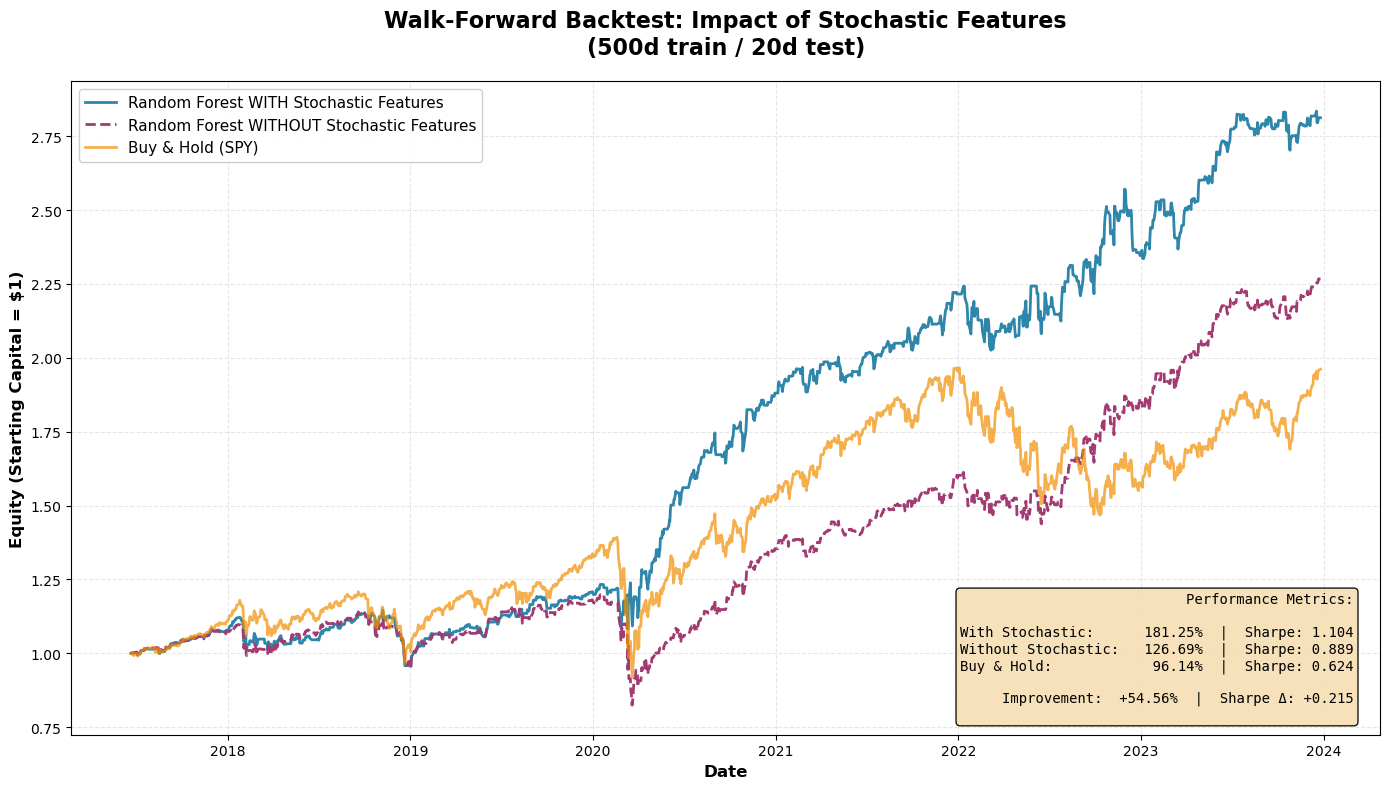


WALK-FORWARD BACKTEST COMPARISON
          Strategy  Total Return (%)  Sharpe Ratio  Final Equity
   With Stochastic        181.249140      1.104165      2.812491
Without Stochastic        126.693601      0.888874      2.266936
        Buy & Hold         96.135014      0.624187      1.961350

STOCHASTIC FEATURES IMPACT
Return Improvement :      +54.56%
Sharpe Improvement :      +0.215
Relative Improvement :    +43.06%


In [17]:
plt.figure(figsize=(14, 8))

plt.plot(equity_with.index, equity_with.values, 
         label='Random Forest WITH Stochastic Features', 
         linewidth=2, color='#2E86AB')

plt.plot(equity_no.index, equity_no.values, 
         label='Random Forest WITHOUT Stochastic Features', 
         linewidth=2, color='#A23B72', linestyle='--')

plt.plot(equity_bh.index, equity_bh.values, 
         label='Buy & Hold (SPY)', 
         linewidth=2, color='#F18F01', alpha=0.7)

plt.title('Walk-Forward Backtest: Impact of Stochastic Features\n(500d train / 20d test)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Equity (Starting Capital = $1)', fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='upper left', framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--')

final_return_with = (equity_with.iloc[-1] - 1) * 100
final_return_no = (equity_no.iloc[-1] - 1) * 100
final_return_bh = (equity_bh.iloc[-1] - 1) * 100

sharpe_with = (wf_with_sto["Random Forest"].mean() / wf_with_sto["Random Forest"].std()) * np.sqrt(252)
sharpe_no = (wf_no_sto["Random Forest"].mean() / wf_no_sto["Random Forest"].std()) * np.sqrt(252)
sharpe_bh = (y_reg.loc[equity_with.index].mean() / y_reg.loc[equity_with.index].std()) * np.sqrt(252)


metrics_text = f"""Performance Metrics:

With Stochastic:     {final_return_with:>7.2f}%  |  Sharpe: {sharpe_with:.3f}
Without Stochastic:  {final_return_no:>7.2f}%  |  Sharpe: {sharpe_no:.3f}
Buy & Hold:          {final_return_bh:>7.2f}%  |  Sharpe: {sharpe_bh:.3f}

Improvement: {final_return_with - final_return_no:>+7.2f}%  |  Sharpe Δ: {sharpe_with - sharpe_no:>+.3f}
"""

plt.text(0.98, 0.02, metrics_text, 
         transform=plt.gca().transAxes,
         fontsize=10, 
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9),
         family='monospace')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("WALK-FORWARD BACKTEST COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Strategy': ['With Stochastic', 'Without Stochastic', 'Buy & Hold'],
    'Total Return (%)': [final_return_with, final_return_no, final_return_bh],
    'Sharpe Ratio': [sharpe_with, sharpe_no, sharpe_bh],
    'Final Equity': [equity_with.iloc[-1], equity_no.iloc[-1], equity_bh.iloc[-1]]
})

print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("STOCHASTIC FEATURES IMPACT")
print("="*80)
print(f"Return Improvement :      {final_return_with - final_return_no:+.2f}%")
print(f"Sharpe Improvement :      {sharpe_with - sharpe_no:+.3f}")
print(f"Relative Improvement :    {((final_return_with / final_return_no) - 1) * 100:+.2f}%")

In [19]:
def max_drawdown(equity):
    peak = equity.cummax()
    dd = equity / peak - 1
    return dd.min() * 100

dd_with = max_drawdown(equity_with)
dd_no   = max_drawdown(equity_no)
dd_bh   = max_drawdown(equity_bh)

print("\nMAX DRAWDOWN (%)")
print(f"With stochastic    : {dd_with:.2f}%")
print(f"Without stochastic : {dd_no:.2f}%")
print(f"Buy & Hold         : {dd_bh:.2f}%")

def calmar_ratio(equity, freq=252):
    total_return = equity.iloc[-1] - 1
    ann_return = (1 + total_return) ** (freq / len(equity)) - 1
    dd = abs(max_drawdown(equity)) / 100
    return ann_return / dd if dd != 0 else np.nan

print("\nCALMAR RATIO")
print(f"With stochastic    : {calmar_ratio(equity_with):.3f}")
print(f"Without stochastic : {calmar_ratio(equity_no):.3f}")
print(f"Buy & Hold         : {calmar_ratio(equity_bh):.3f}")

def hit_ratio(returns):
    return (returns > 0).mean() * 100

ret_with = equity_with.pct_change().dropna()
ret_no   = equity_no.pct_change().dropna()
ret_bh   = equity_bh.pct_change().dropna()

print("\nHIT RATIO (%)")
print(f"With stochastic    : {hit_ratio(ret_with):.2f}%")
print(f"Without stochastic : {hit_ratio(ret_no):.2f}%")
print(f"Buy & Hold         : {hit_ratio(ret_bh):.2f}%")



MAX DRAWDOWN (%)
With stochastic    : -16.45%
Without stochastic : -31.24%
Buy & Hold         : -34.10%

CALMAR RATIO
With stochastic    : 1.047
Without stochastic : 0.429
Buy & Hold         : 0.320

HIT RATIO (%)
With stochastic    : 34.17%
Without stochastic : 34.11%
Buy & Hold         : 54.97%


Interpretation
- The walk-forward strategy is evaluated entirely out-of-sample, ensuring that the model never uses future information.
- Compared to a fixed train/test split, performance is smoother and more conservative, reflecting realistic deployment conditions.
- Despite this stricter validation, the strategy consistently outperforms Buy & Hold in both return and risk-adjusted metrics.
- The inclusion of stochastic features improves performance stability, leading to higher Sharpe and Calmar ratios without increasing drawdowns.
- This confirms that results are not driven by a single favorable regime, but are robust across multiple market environments.
- Overall, walk-forward validation provides a more reliable and deployable estimate of real-world performance.